### Torchvison transform

In [1]:
import detection_transforms as dt
from data import BedsoreDataset
from utils import draw_bbox
import torch
import random
from torchvision import transforms

In [2]:
# tfmc = Compose([RandomCrop(), ToTensor()])
# tfmc = Compose([])

trans_prob = 0.5
tfmc = dt.Compose([
            dt.RandomCrop(1),
            dt.RandomGaussianBlur((0.1,1),1),
             dt.RandomColorJitter(trans_prob),
            (dt.RandomHorizontalFlip(0.8), dt.RandomVerticalFlip(0.8), dt.RandomRotate(0.8)),
            dt.RandomResize(trans_prob),
            dt.ToTensor(),
            dt.RandomErasing(),
        ])

ds = BedsoreDataset('data', transforms=tfmc)

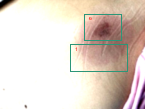

In [17]:
image,target = ds[33]
draw_bbox(image,target)

In [50]:
image,target = ds[1]
W,H = image.size
# _, H,W = image.size()
min_minx = target['boxes'][:,0].min()
min_miny = target['boxes'][:,1].min()
min_maxx = target['boxes'][:,2].max()
min_maxy = target['boxes'][:,3].max()
a = int(random.uniform(0,min_minx))
b = int(random.uniform(0,min_miny))
c = int(random.uniform(min_maxx,W))
d = int(random.uniform(min_maxy,H))
target['boxes'][:,0] -= a
target['boxes'][:,2] -= a
target['boxes'][:,1] -= b
target['boxes'][:,3] -= b

a,b,c,d

TypeError: cannot unpack non-iterable builtin_function_or_method object

In [155]:
image_cropped = image.crop((a,b,c,d))

In [31]:
image_cropped = transforms.ToTensor()(image_cropped)
draw_bbox(image_cropped,target)

NameError: name 'image_cropped' is not defined

### Album

In [1]:
import albumentations as A
from data import BedsoreDataset
from utils import draw_bbox
from torchvision import transforms as T
import numpy as np
from albumentations.pytorch import ToTensorV2,ToTensor
import torch
from utils import batch2pil, draw_bbox, out2detfile
from PIL import Image
from tqdm import tqdm

In [30]:
atfmc = A.Compose([
#     A.RandomScale(p=0.5),
#     A.RandomShadow(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(p=0.5),
#     A.RandomBrightnessContrast(p=0.3),
#     A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ToTensor(),
    ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))
# atfmc = None

ds = BedsoreDataset('data', transforms=atfmc)
ids = 400-5
image,target = ds[ids]

SZ = 256
ry = Image.new("RGB",(SZ,SZ),(255,0,0))
fr = Image.new("RGB",(SZ,SZ),(255,255,0))
hs = Image.new("RGB",(SZ,SZ),(0,0,255))
tissue = {7:hs, 8:fr, 9:ry}

In [32]:
# 遍历检查脚本
for i in tqdm(range(0,len(ds))):
    image,target = ds[i]
#     print(i,target['fname'])
    
    good_labels = target['labels']
    good_masks = target['masks'][good_labels>6]
    good_labels = good_labels[good_labels>6]
    img_out = draw_bbox(image,target).resize((SZ,SZ))

    for i,t in enumerate(good_labels):
        mask = batch2pil(((good_masks[i])>0.5).float()).resize((SZ,SZ))
        mask = np.array(mask)*0.5
        mask = Image.fromarray(mask.astype('uint8')).convert('L')
        img_out = Image.composite(tissue[t.item()], img_out, mask)
    img_out.save(f"check_image/{target['fname']}.jpg")

100%|██████████| 1363/1363 [10:15<00:00,  2.22it/s]


B03_00011


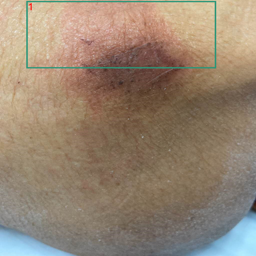

In [31]:
SZ = 256
ry = Image.new("RGB",(SZ,SZ),(255,0,0))
fr = Image.new("RGB",(SZ,SZ),(255,255,0))
hs = Image.new("RGB",(SZ,SZ),(0,0,255))
tissue = {7:hs, 8:fr, 9:ry}

print(target['fname'])
good_labels = target['labels']
good_masks = target['masks'][good_labels>6]
good_labels = good_labels[good_labels>6]
img_out = draw_bbox(image,target).resize((SZ,SZ))

for i,t in enumerate(good_labels):
    mask = batch2pil(((good_masks[i])>0.5).float()).resize((SZ,SZ))
    mask = np.array(mask)*0.5
    mask = Image.fromarray(mask.astype('uint8')).convert('L')
    img_out = Image.composite(tissue[t.item()], img_out, mask)
    
img_out

In [ ]:
batch2pil((target['masks']>0.5)[0].float()).resize((256,256))

In [6]:
target['labels']

tensor([5, 8, 7, 7])

In [8]:
valid_masks = target['masks'][target['labels']>6]